<a href="https://colab.research.google.com/github/tonytarizzo/paddyRiceCompetition/blob/main/paddyCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai
!pip install timm
#!pip install Pillow


try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import*
import timm

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [ ]:
path


Path('paddy-disease-classification')

In [ ]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/test_images')]

In [ ]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


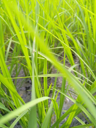

In [ ]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [ ]:
from fastcore.parallel import *
from PIL import Image as PILImage


def f(o): return (o, PILImage.open(o).size)
sizes = parallel(f, files, n_workers=8)

incorrect_size_files = [f[0] for f in sizes if f[1] != (480, 640)]

def rotate_and_save(filepath):
    with PILImage.open(filepath) as img:
        rotated = img.rotate(90, expand=True)
        rotated.save(filepath)

parallel(rotate_and_save, incorrect_size_files, n_workers=8)

#pd.Series(sizes).value_counts()


(#0) []

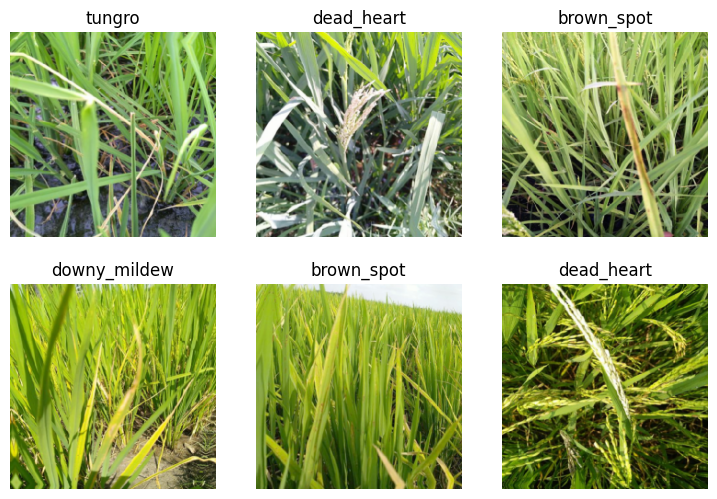

In [ ]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))
#bs=16
dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()
#resnet26dconvnext_tiny

SuggestedLRs(valley=0.0006918309954926372, slide=0.0063095735386013985)

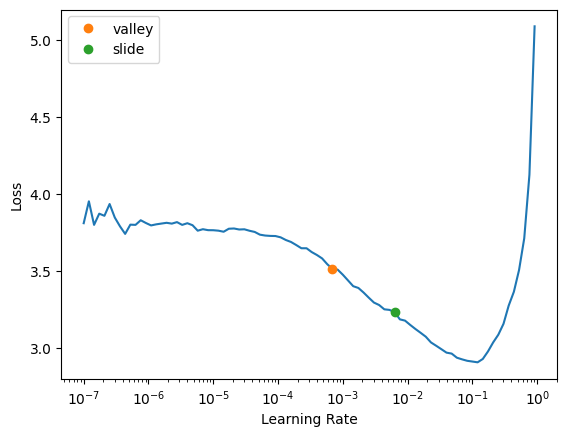

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
learn.fine_tune(9, 0.03)

epoch,train_loss,valid_loss,error_rate,time
0,1.761288,1.298628,0.372417,01:30


epoch,train_loss,valid_loss,error_rate,time
0,0.850286,0.464532,0.141759,01:29
1,0.603574,0.423172,0.128784,01:28
2,0.488721,0.364328,0.115329,01:29
3,0.329550,0.246326,0.075925,01:29
4,0.230876,0.190898,0.050937,01:27
5,0.164185,0.145567,0.037001,01:29
6,0.095681,0.133020,0.033157,01:26
7,0.076471,0.120444,0.031716,01:29
8,0.053284,0.118780,0.029313,01:29


In [ ]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [ ]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [ ]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([7, 8, 3,  ..., 8, 1, 5])

In [ ]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [ ]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [ ]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████| 70.4k/70.4k [00:02<00:00, 24.9kB/s]
